# Snapshot Demo: Cycle and Lemniscate Graphs

This notebook demonstrates the enhanced snapshot capture pipeline for PropFlow's belief propagation engine. We build a cycle graph and a lemniscate (∞) graph, run short simulations with snapshots enabled, and inspect the captured artefacts.


In [1]:
from __future__ import annotations

from datetime import datetime
from pathlib import Path
import json

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from propflow.bp.engine_base import BPEngine
from propflow.configs import create_random_int_table
from propflow.snapshots.utils import latest_snapshot
from propflow.utils.fg_utils import FGBuilder
from propflow.snapshots import SnapshotAnalyzer


In [2]:
RUN_ROOT = Path("results/notebooks/snapshot_demo")
RUN_ROOT.mkdir(parents=True, exist_ok=True)
np.random.seed(7)


def _plot_factor_graph(graph, ax, title: str) -> None:
    labels = {node: getattr(node, "name", str(node)) for node in graph.G.nodes}
    pos = nx.spring_layout(graph.G, seed=42)
    var_nodes = list(graph.variables)
    fac_nodes = list(graph.factors)
    ax.set_title(title)
    ax.axis("off")
    nx.draw_networkx_nodes(graph.G, pos, nodelist=var_nodes, node_color="#4c72b0", node_size=600, ax=ax, label="Variables")
    nx.draw_networkx_nodes(graph.G, pos, nodelist=fac_nodes, node_color="#dd8452", node_shape="s", node_size=500, ax=ax, label="Factors")
    nx.draw_networkx_edges(graph.G, pos, ax=ax, alpha=0.3)
    nx.draw_networkx_labels(graph.G, pos, labels=labels, font_size=10, ax=ax)
    ax.legend(loc="upper right")


def _run_demo(label: str, graph, max_steps: int = 6):
    run_dir = RUN_ROOT / f"{label}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    run_dir.mkdir(parents=True, exist_ok=True)


    engine = BPEngine(
        factor_graph=graph,
        use_bct_history=True,
    )
    engine.run(max_iter=max_steps)

    return engine


def _load_latest_meta(result: dict) -> dict:
    manifest = result["manifest"]
    if not manifest.get("steps"):
        return {}
    last_step = manifest["steps"][-1]["step"]
    meta_path = result["run_dir"] / f"step_{int(last_step):04d}" / "meta.json"
    if meta_path.exists():
        return json.loads(meta_path.read_text())
    return {}


In [3]:
cycle_graph = FGBuilder.build_cycle_graph(
    num_vars=6,
    domain_size=3,
    ct_factory=create_random_int_table,
    ct_params={"low": 1, "high": 7},
)
cycle_result = _run_demo("cycle", cycle_graph, max_steps=6)



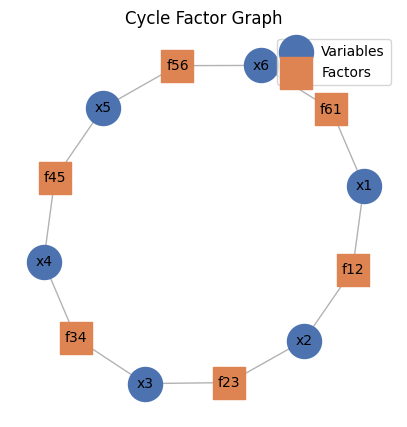

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))
_plot_factor_graph(cycle_graph, ax, "Cycle Factor Graph")
plt.show()



In [5]:
lemn_graph = FGBuilder.build_lemniscate_graph(
    num_vars=8,
    domain_size=3,
    ct_factory=create_random_int_table,
    ct_params={"low": 1, "high": 7},
)
lemn_result = _run_demo("lemniscate", lemn_graph, max_steps=8)


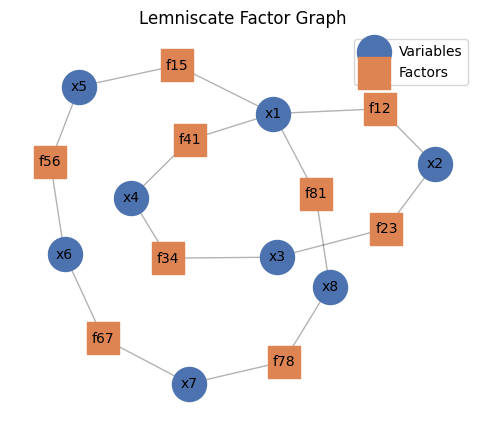

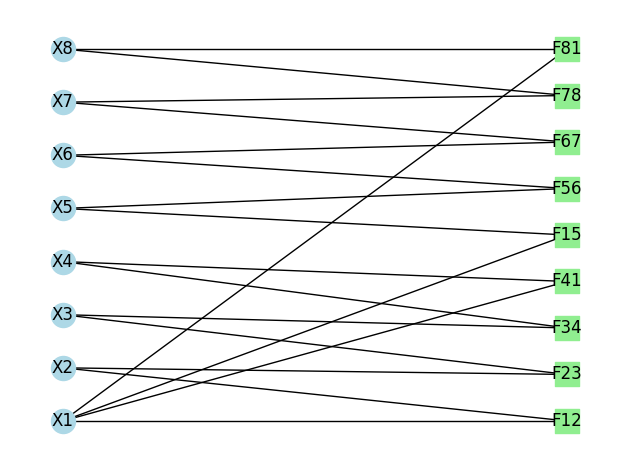

In [6]:
fig, ax = plt.subplots(figsize=(6, 5))
_plot_factor_graph(lemn_graph, ax, "Lemniscate Factor Graph")
plt.show()
lemn_graph.visualize()

snapshots = lemn_result.snapshots

/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/visualizer.py:932: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/visualizer.py:652: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/visualizer.py:872: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


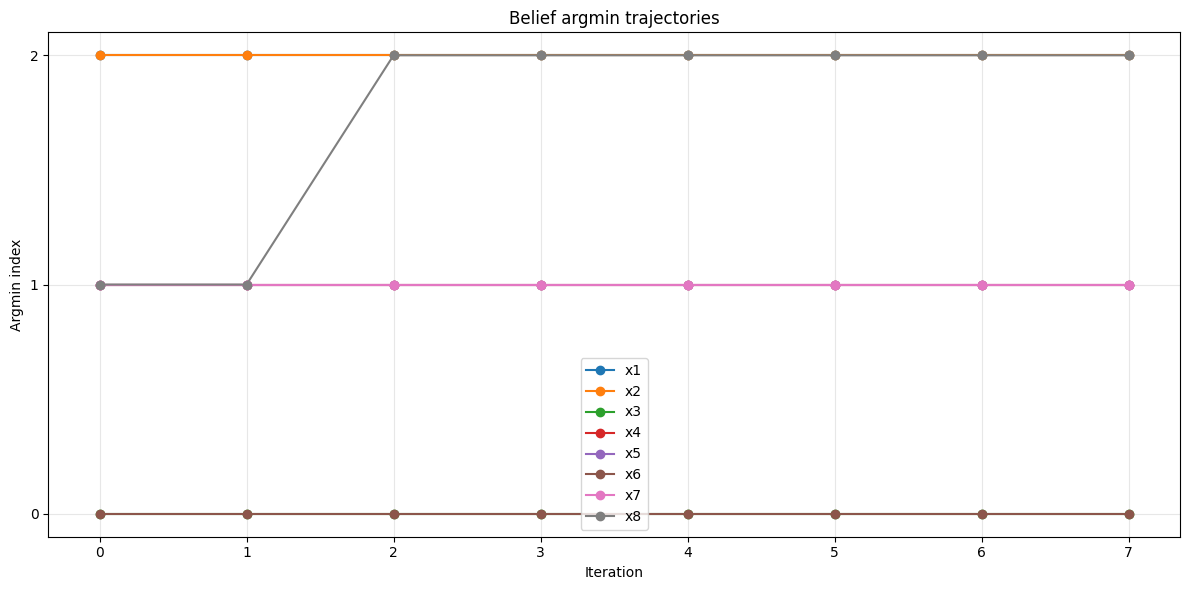

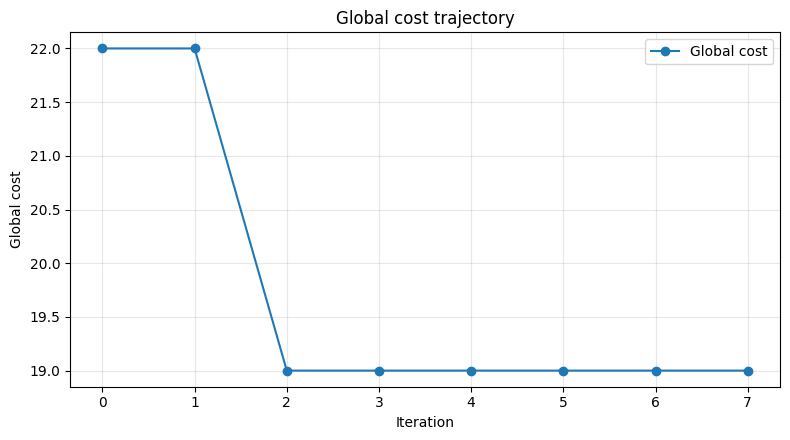

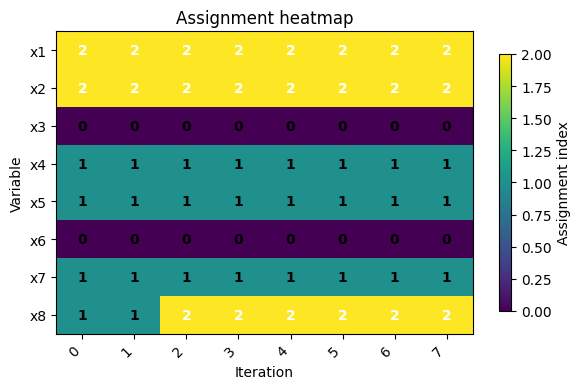

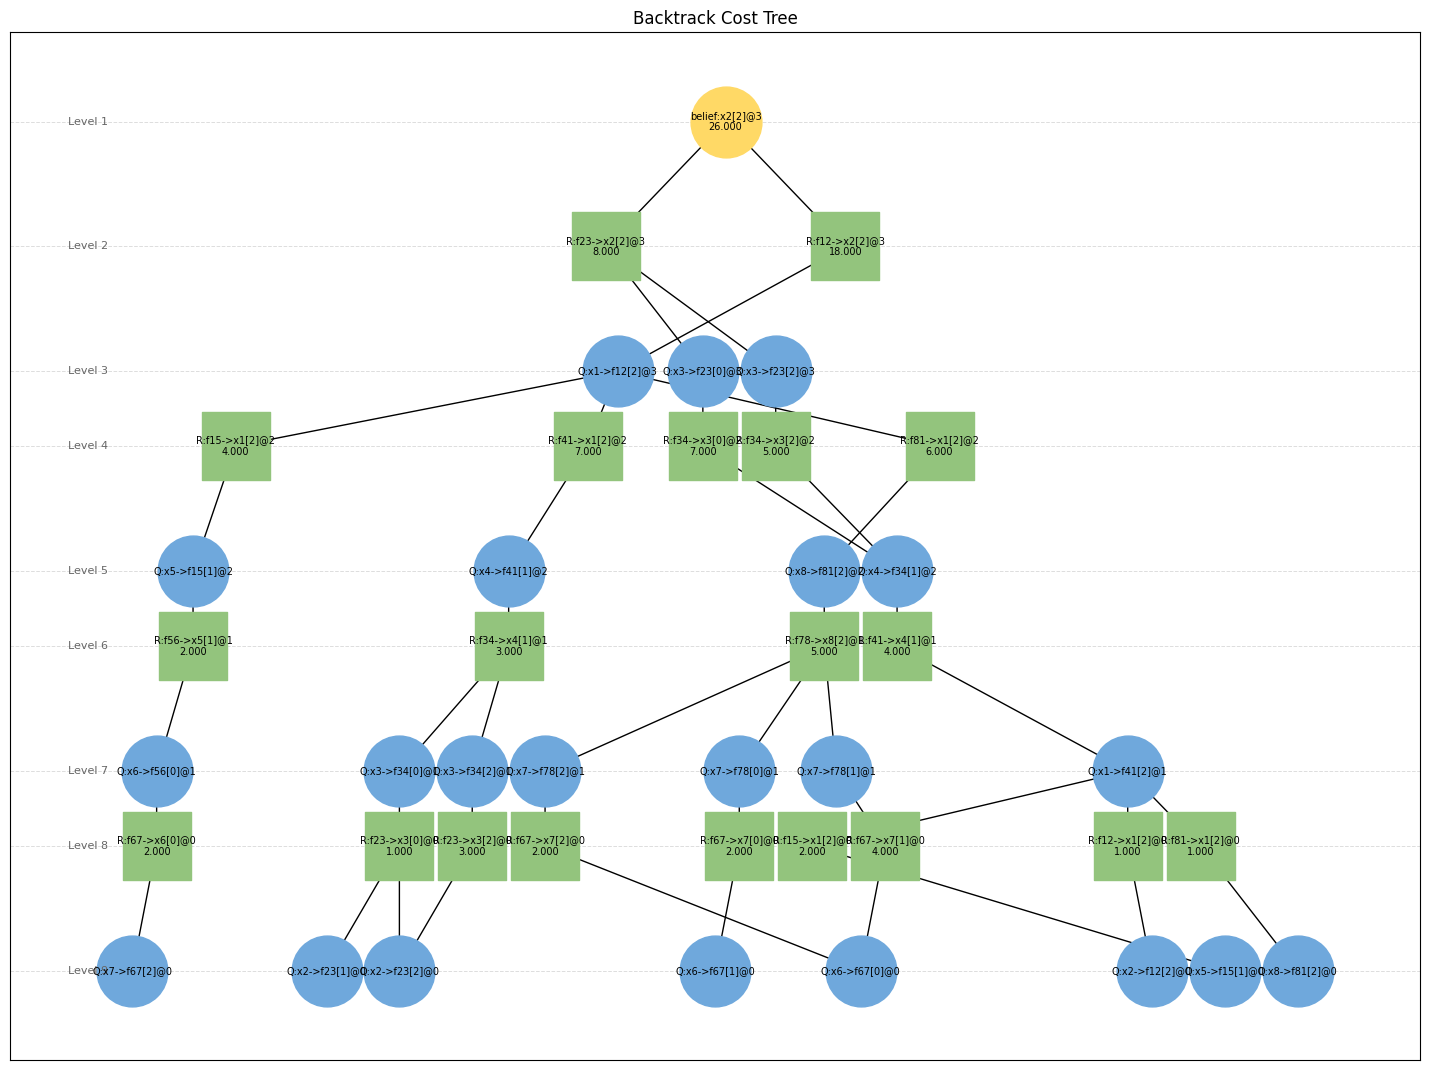

array([[4., 6., 3.],
       [4., 6., 5.],
       [5., 6., 1.]])

In [7]:
from propflow.snapshots.visualizer import SnapshotVisualizer


viz = SnapshotVisualizer(snapshots=snapshots)
viz.plot_argmin_per_variable(layout = "combined")
viz.plot_global_cost()
viz.plot_assignment_heatmap()
viz.plot_bct("x2",3)
viz.factor_cost_matrix("f12",0)

# Run analysis:
## Modules that will be checked:
```python 
ç
```


In [ ]:
from propflow.snapshots import SnapshotAnalyzer

analyzer = SnapshotAnalyzer(snapshots=snapshots)

print(analyzer.beliefs_per_variable())
print(analyzer.cycle_metrics(1))



{'x1': [2, 2, 2, 2, 2, 2, 2, 2], 'x2': [2, 2, 2, 2, 2, 2, 2, 2], 'x3': [0, 0, 0, 0, 0, 0, 0, 0], 'x4': [1, 1, 1, 1, 1, 1, 1, 1], 'x5': [1, 1, 1, 1, 1, 1, 1, 1], 'x6': [0, 0, 0, 0, 0, 0, 0, 0], 'x7': [1, 1, 1, 1, 1, 1, 1, 1], 'x8': [1, 1, 2, 2, 2, 2, 2, 2]}
{'num_cycles': 4, 'has_cycles': True}


# lets check now for a general graph:


In [23]:
from propflow.utils import FGBuilder,CTFactories   
# lets check now for a general graph:
fg = FGBuilder.build_random_graph(
    num_vars=10,
    domain_size=5,
    ct_factory=CTFactories.RANDOM_INT,
    ct_params={"low": 1, "high": 10},
    density=0.5
)
engine = BPEngine(fg)

engine.run(max_iter=10)
snapshots = engine.snapshots
analyzer = SnapshotAnalyzer(snapshots=snapshots)
jacobian = analyzer.jacobian(2)
print(jacobian)
analyzer.beliefs_per_variable()
    

<List of Lists sparse matrix of dtype 'float64'
	with 2190 stored elements and shape (640, 640)>
  Coords	Values
  (0, 330)	1.0
  (0, 340)	1.0
  (0, 350)	1.0
  (0, 360)	1.0
  (1, 331)	1.0
  (1, 341)	1.0
  (1, 351)	1.0
  (1, 361)	1.0
  (2, 332)	1.0
  (2, 342)	1.0
  (2, 352)	1.0
  (2, 362)	1.0
  (3, 333)	1.0
  (3, 343)	1.0
  (3, 353)	1.0
  (3, 363)	1.0
  (4, 334)	1.0
  (4, 344)	1.0
  (4, 354)	1.0
  (4, 364)	1.0
  (5, 320)	1.0
  (5, 340)	1.0
  (5, 350)	1.0
  (5, 360)	1.0
  (6, 321)	1.0
  :	:
  (615, 250)	1.0
  (616, 250)	1.0
  (617, 250)	1.0
  (618, 250)	1.0
  (619, 250)	1.0
  (620, 311)	1.0
  (621, 311)	1.0
  (622, 311)	1.0
  (623, 311)	1.0
  (624, 311)	1.0
  (625, 275)	1.0
  (626, 275)	1.0
  (627, 275)	1.0
  (628, 275)	1.0
  (629, 275)	1.0
  (630, 316)	1.0
  (631, 316)	1.0
  (632, 316)	1.0
  (633, 316)	1.0
  (634, 316)	1.0
  (635, 42)	1.0
  (636, 42)	1.0
  (637, 42)	1.0
  (638, 42)	1.0
  (639, 42)	1.0


{'x1': [2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
 'x10': [2, 2, 2, 2, 2, 2, 0, 2, 2, 2],
 'x2': [3, 4, 4, 1, 4, 1, 4, 1, 4, 2],
 'x3': [2, 1, 3, 2, 2, 2, 0, 2, 0, 2],
 'x4': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'x5': [1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
 'x6': [0, 2, 2, 3, 2, 3, 2, 2, 2, 1],
 'x7': [4, 0, 0, 3, 0, 3, 0, 3, 2, 4],
 'x8': [2, 2, 0, 2, 1, 2, 0, 2, 0, 2],
 'x9': [1, 1, 2, 2, 2, 3, 2, 2, 2, 2]}